In [42]:
# 데이터 크롤링 모듈
from bs4 import BeautifulSoup
import re
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import requests
import requests
import json
# 한글 폰트 사용하기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [95]:
group1 = pd.read_csv(r"C:\Users\injoo\광주 인공지능 사관학교\웜업 프로젝트\KBO 데이터 시각화\Dataset\player_infos_add_v01.csv")
all_players = pd.read_csv(r"C:\Users\injoo\광주 인공지능 사관학교\웜업 프로젝트\KBO 데이터 시각화\Dataset\players_salary_ID.csv")

In [96]:
group1.columns.values

array(['Unnamed: 0', '순위', '선수명', '팀명', '타율', '경기수', '타석', '타수', '득점',
       '안타', '2루타', '3루타', '홈런', '루타', '타점', '희생번트', '희생플라이', '선수ID',
       '생년월일', '신장', '체중', '입단계약금', '연봉', '지명순위', '볼넷', '고의사구', '사구',
       '삼진', '병살타', '장타율', '출루율', '실책', '도루성공률', '멀티히트', '출루율add장타율',
       '득점권타율', '대타타율', '사진URL'], dtype=object)

# KBO 평균 연봉은 1억 5천만원 정도이다. 
# 하지만 최근 리그 수준 저하 논란과 함께 많은 연봉을 받고 성적은 좋지 않은 '먹튀'들이 많아 지고 있다. 데이터로 알아보자

## 일단 KBO 홈페이지에 등록되어있는 선수 전체 데이터를 분석해보자

In [45]:
all_players = pd.read_csv(r"C:\Users\injoo\광주 인공지능 사관학교\웜업 프로젝트\KBO 데이터 시각화\Dataset\players_salary_ID.csv")

In [46]:
all_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  893 non-null    int64  
 1   playerID    893 non-null    int64  
 2   name        893 non-null    object 
 3   team        893 non-null    object 
 4   salary      893 non-null    float64
 5   position    893 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 42.0+ KB


In [47]:
all_players.groupby("team").count()

,Unnamed: 0,playerID,name,salary,position
team,,,,,
KIA 타이거즈,84,84,84,84,84
KT 위즈,97,97,97,97,97
LG 트윈스,85,85,85,85,85
NC 다이노스,94,94,94,94,94
SK 와이번스,84,84,84,84,84
고양 히어로즈,15,15,15,15,15
두산 베어스,92,92,92,92,92
롯데 자이언츠,82,82,82,82,82
삼성 라이온즈,83,83,83,83,83


### 현재 총 893명의 선수가 등록되어 있으며, 군복무 중인 선수들의 팀인 상무와 퓨처스 리그인 고양 히어로즈는 제외하도록 하자

In [48]:
all_players['team'] = all_players['team'].apply(lambda x: x.rstrip())

In [49]:
all_players = all_players[ (all_players['team']!='상무') & (all_players['team']!='고양 히어로즈') ]

In [50]:
team_info = all_players.groupby("team").count()

In [51]:
team_info

,Unnamed: 0,playerID,name,salary,position
team,,,,,
KIA 타이거즈,84,84,84,84,84
KT 위즈,97,97,97,97,97
LG 트윈스,85,85,85,85,85
NC 다이노스,94,94,94,94,94
SK 와이번스,84,84,84,84,84
두산 베어스,92,92,92,92,92
롯데 자이언츠,82,82,82,82,82
삼성 라이온즈,83,83,83,83,83
키움 히어로즈,65,65,65,65,65


### 선수들의 연봉을 시각화 해보자

Text(0, 0.5, '사람 수')

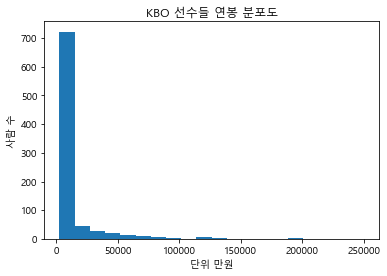

In [62]:
plt.hist(all_players['salary'], bins=20)
plt.title("KBO 선수들 연봉 분포도")
plt.xlabel("단위 만원")
plt.ylabel("사람 수")

### 그래프가 한쪽에 치우침이 심해서 잘 나타나지 않는다. 연봉 1억 미만으로 상한선을 둬보자

Text(0, 0.5, '사람 수')

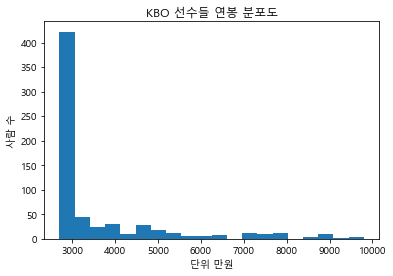

In [66]:
plt.hist(all_players[all_players['salary']<10000]['salary'], bins=20)
plt.title("KBO 선수들 연봉 분포도")
plt.xlabel("단위 만원")
plt.ylabel("사람 수")

### 800명 가량의 선수 중에서 400명 넘는 선수가 3000만원 이하의 연봉을 받고 있다.

### 1군 선수 중에서 주전 선수들로 범위를 좁혀보자

In [107]:
group1_salary = group1[['선수명', '팀명', '연봉']]

In [108]:
group1_salary

,선수명,팀명,연봉
0,조수행,두산,4500만원
1,페르난데스,두산,400000달러
2,허경민,두산,48000만원
3,오재일,두산,47000만원
4,신성현,두산,4800만원
...,...,...,...
331,정영일,SK,11000만원
332,조영우,SK,3300만원
333,하재훈,SK,15000만원
334,현원회,SK,2700만원


In [109]:
# 결측치를 제거해주자
group1_salary = group1_salary.dropna(axis=0)

In [110]:
group1_salary

,선수명,팀명,연봉
0,조수행,두산,4500만원
1,페르난데스,두산,400000달러
2,허경민,두산,48000만원
3,오재일,두산,47000만원
4,신성현,두산,4800만원
...,...,...,...
330,오원석,SK,2700만원
331,정영일,SK,11000만원
332,조영우,SK,3300만원
333,하재훈,SK,15000만원


### 선수들의 연봉을 숫자형으로 바꿔주고, 달러로 받는 용병 투수들의 금액을 1.1배하여 한화로 환산해주자

In [111]:
group1_salary['연봉'] = group1_salary['연봉'].apply(lambda x: x.rstrip())

C:\Users\injoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [181]:
def change_salary(x):
    if x[-2:]=="만원":
        return int(x[:-2])
    else:
        tmp = x[:-2]
        tmp = int(tmp)
        tmp /=10
        tmp *= 1.1
        return int(tmp)

In [113]:
group1_salary['연봉'] = group1_salary['연봉'].apply(lambda x: change_salary(x))

C:\Users\injoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [114]:
group1_salary

,선수명,팀명,연봉
0,조수행,두산,4500.0
1,페르난데스,두산,44000.0
2,허경민,두산,48000.0
3,오재일,두산,47000.0
4,신성현,두산,4800.0
...,...,...,...
330,오원석,SK,2700.0
331,정영일,SK,11000.0
332,조영우,SK,3300.0
333,하재훈,SK,15000.0


Text(0, 0.5, '사람 수')

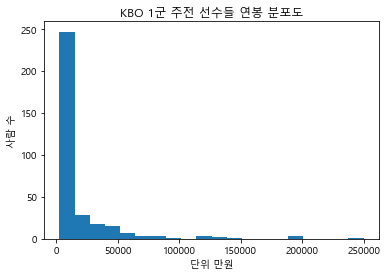

In [118]:
plt.hist(group1_salary['연봉'], bins=20)
plt.title("KBO 1군 주전 선수들 연봉 분포도")
plt.xlabel("단위 만원")
plt.ylabel("사람 수")

Text(0, 0.5, '사람 수')

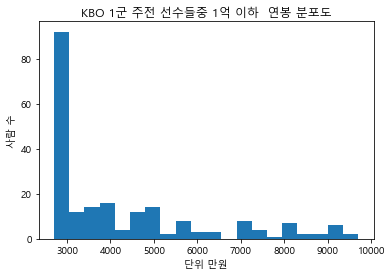

In [119]:
plt.hist(group1_salary[group1_salary['연봉']<10000]['연봉'], bins=20)
plt.title("KBO 1군 주전 선수들중 1억 이하  연봉 분포도")
plt.xlabel("단위 만원")
plt.ylabel("사람 수")

### 1군 주전 선수들도 다른 선수들만큼은 아니지만 편차가 심한 것을 알 수 있다

### 선수들을 연봉 분위수에 따라서 카테고리를 나누고, 같은 카테고리 대비 얼마나 성적을 내고 있는지 확인해보자

In [173]:
df = group1 = pd.read_csv(r"C:\Users\injoo\광주 인공지능 사관학교\웜업 프로젝트\KBO 데이터 시각화\Dataset\player_infos_add_v01.csv")

In [172]:
df.columns.values

array(['Unnamed: 0', '순위', '선수명', '팀명', '타율', '경기수', '타석', '타수', '득점',
       '안타', '2루타', '3루타', '홈런', '루타', '타점', '희생번트', '희생플라이', '선수ID',
       '생년월일', '신장', '체중', '입단계약금', '연봉', '지명순위', '볼넷', '고의사구', '사구',
       '삼진', '병살타', '장타율', '출루율', '실책', '도루성공률', '멀티히트', '출루율add장타율',
       '득점권타율', '대타타율', '사진URL'], dtype=object)

In [174]:
df = df.drop(columns=['Unnamed: 0', '순위', '사진URL', '신장', '체중', '입단계약금', '지명순위', '대타타율', '생년월일'])

In [175]:
df.columns.values

array(['선수명', '팀명', '타율', '경기수', '타석', '타수', '득점', '안타', '2루타', '3루타',
       '홈런', '루타', '타점', '희생번트', '희생플라이', '선수ID', '연봉', '볼넷', '고의사구',
       '사구', '삼진', '병살타', '장타율', '출루율', '실책', '도루성공률', '멀티히트',
       '출루율add장타율', '득점권타율'], dtype=object)

In [184]:
df = df.dropna(axis=0)

In [185]:
df['연봉']

0        4500만원
1      400000달러
2       48000만원
3       47000만원
4        4800만원
         ...   
330      2700만원
331     11000만원
332      3300만원
333     15000만원
334      2700만원
Name: 연봉, Length: 335, dtype: object

In [186]:
df['연봉'] = df['연봉'].apply(lambda x: change_salary(x))

### 타자만 고려해야하니 타석 수가 5개 이상인 타자들만 뽑아내자

In [202]:
df = df[ df['타석'] > 5]

### 연봉의 분위수를 알아보자

In [203]:
df['연봉'].quantile([0.25, 0.5, 0.75, 1])

0.25      3500.0
0.50      7000.0
0.75     25000.0
1.00    250000.0
Name: 연봉, dtype: float64

In [211]:
def give_qunatile(x):
    if x<=3500:
        return "하위25퍼"
    elif x<=7000:
        return "하위50퍼"
    elif x<=25000:
        return "상위50퍼"
    elif x<=250000:
        return "상위25퍼"

In [212]:
df['연봉구간'] = df['연봉'].apply(lambda x: give_qunatile(x))

In [215]:
df.columns.values

array(['선수명', '팀명', '타율', '경기수', '타석', '타수', '득점', '안타', '2루타', '3루타',
       '홈런', '루타', '타점', '희생번트', '희생플라이', '선수ID', '연봉', '볼넷', '고의사구',
       '사구', '삼진', '병살타', '장타율', '출루율', '실책', '도루성공률', '멀티히트',
       '출루율add장타율', '득점권타율', '연봉구간'], dtype=object)

In [217]:
df.groupby('연봉구간').mean().reset_index().round(2)

,연봉구간,경기수,타석,타수,득점,안타,2루타,3루타,홈런,루타,...,선수ID,연봉,볼넷,고의사구,사구,삼진,병살타,실책,멀티히트,득점권타율
0,상위25퍼,77.57,309.29,271.17,43.59,80.34,14.81,0.91,9.95,126.83,...,71652.41,68903.43,30.07,1.36,3.93,47.16,6.71,3.17,21.79,0.31
1,상위50퍼,57.12,174.38,153.71,21.53,40.71,6.16,0.72,3.78,59.64,...,67524.76,13844.83,15.24,0.24,2.26,30.74,3.98,2.86,9.55,0.26
2,하위25퍼,30.79,65.86,59.11,7.98,13.84,2.19,0.25,0.84,19.06,...,63167.95,2928.57,4.70,0.00,0.70,14.13,1.24,1.59,2.81,0.22
3,하위50퍼,39.75,93.78,81.32,12.27,20.45,3.70,0.27,1.60,29.48,...,66234.80,4948.33,9.18,0.12,1.30,19.28,1.78,1.72,4.42,0.22
